## Libraries

### Import Data Analytics Libraries
- Pandas
- Numpy
- Matplotlib
- Datetime

In [421]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

In [422]:
from sklearn.preprocessing import MinMaxScaler

### Import Project Specific Libraries
- **Yahoo Finance (yfinance)**: Gather ticker data
- **Backtrader Technical Analysis Library (bta-lib)**: Gather trends and pattern indicators

In [423]:
import btalib
import yfinance as yf

### Import Web Scraping Libraries
- **requests**: Gather web data
- **urllib**: Gather web data
- **BeautifulSoup**: Extract web data

In [424]:
import requests
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

### Import Deep Learning Libraries
- **PyTorch**: Create neutral networks
- **TensorBoard**: Visualize training statistics


In [425]:
import torch
import torch.utils.tensorboard as tb


### Import Natural Language Processing Tools
- **transformers**: Use pre-trained deep learning models

In [426]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

### Import API Keys
- **config**: Holds all private API keys


In [427]:
from config import *

## Data Collection

We will be using Yahoo Finance in order to find the ticker data. This data will include:

- **Date/DateTime**: Index
- **Open**: Price of asset at beginning of Date/Datetime
- **High**: Highest price of asset during Date/Datetime
- **Low**: Lowest price of asset during Date/Datetime
- **Close**: Price of stock at end of Date/Datetime
- **Adj Close**: Close price adjusted due to corporate actions such as dividend payouts, stock splits, or the issuance of more shares

In [428]:
def get_data(symbol, interval = "1d", start_date = "2020-01-01", end_date = "2021-12-31"):
   
    '''
    Returns asset information

            Parameters:
                    symbol (string): ticker symbol for lookup
                    interval (string): periods between datapoints (valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo)
                    start_date (string): format YYYY-MM-DD
                    end_date (string): format YYYY-MM-DD
            Returns:
                    (DateFrame): Asset Information  
    '''

    return yf.download(symbol, start=start_date, end=end_date, interval=interval)

In [429]:
data = get_data("AAPL")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.894325,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,73.175919,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.759003,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.412117,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.593033,132079200


# Feature Construction

## Technical Analysis

A part of this study is to try and see if a model can use technical analysis (TA) as a way to create a trading strategy

Technical analysis is the study of trends and patterns in order to predict profitable trading decisions. There are 4 types of indictors we will in this study:

- trend indictors
- momentum indicators
- volatility indicators
- volume indicators. 

Typically, traders use only a 2-3 indictors for their strategy, however, our job is to also see if a model can determine which indictors are more important when making these decisions as well.

In order to add TA to our data, we will be using bta-lib.

Below, we will go in depth into a few indictors and how they are used

### Simple Moving Average

The simple moving average indictor is a trend indictor that finds the average price within a certain window of time. This helps smooth out the noise in price changes and helps trades seen the general trend of the asset's price.

Many traders also use two different moving averages on the same asset. One moving average would have a longer period than the other. In order to buy, the shorter moving average would have to greater than the longer moving average, indicating that there is a rapid change in price upwards. The same is true vice versa.

We will test if the model could potentially recognize this pattern and gauge if it is useful.



![SMA](images/SMA.PNG)

This chart shows Apple stock prices using the moving average indictors. The purple line shows the short term moving average of 12 days and the yellow line shows the long term moving average of 26 days. The green "up" arrow shows where a trader would buy and the red "down" arrow shows where a trader would sell using this strategy.

In [430]:
def get_MA(data, short_period=12, long_period=26):

    '''
    Adds Moving Averages to asset data

        Parameters:
                data (DataFrame): asset data
                short_period (int): period over moving average taken (<long_period)
                long_period (int): period over moving average taken (>short_period)

        Returns:
                (DateFrame): Asset Information
    '''

    # get Moving Averages
    ShortMA = btalib.sma(data, period=short_period)
    LongMA = btalib.sma(data, period=long_period)

    # add to current data
    data["ShortMA"] = ShortMA.df
    data["LongMA"] = LongMA.df

    return data

### Exponential Moving Average

The exponential moving average is similar to the simple moving average, however, it gives higher weigh to more recent changes within the window of time. This could better help find short term price trends than the simple moving average.

Note: may only use this rather than the simple moving average for the model.

![EMA](images/EMA.PNG)

This chart shows Apple stock prices using the exponential moving average indictors. The purple line shows the short term moving average of 12 days and the yellow line shows the long term moving average of 26 days. The green "up" arrow shows where a trader would buy and the red "down" arrow shows where a trader would sell using this strategy.

In [431]:
def get_EMA(data, short_period=12, long_period=26):
    '''
    Adds Exponential Moving Averages to asset data

        Parameters:
                data (DataFrame): asset data
                short_period (int): period over moving average taken (<long_period)
                long_period (int): period over moving average taken (>short_period)

        Returns:
                (DateFrame): Asset Information 
    '''
    # get Exponential Moving Averages
    ShortEMA = btalib.ema(data, period=12)
    LongEMA = btalib.ema(data, period=26)
    
    # add to data
    data["ShortEMA"] = ShortEMA.df
    data["LongEMA"] = LongEMA.df

    return data

### Bollinger Bands


The Bollinger Bands indictors is a kind of volatility indictor which uses the moving average over a portion of days and finds a certain standard deviation above and below that moving average. This indictor relies on the theory of mean reversion where asset prices, after spikes in price changes, revert towards the moving average of price. This indictor also shows how volatile an asset is; if the bands are farther apart, then more volatile the asset is. Traders may use this strategy by buying an asset when the price reaches the lower standard deviation and then sell at the higher standard deviation. Usually, traders use 2 standard deviations away from the mean and have a moving average window of 20 periods.

![Simple Bollinger Bands](images/simpleBBands.PNG)

The purple lines are two standard deviations and the yellow line is the moving average.

Of course, this strategy by itself or unaltered is not perfect, as it may miss out on trends. However, with stop losses (selling if price drops below certain value), band line slopes, and pattern recognition, this strategy may help the model learn more about correct buy and sell signals.

Another possible way to improve this strategy is to add another set of Bollinger Bands that have a different standard deviation.

![Double Bollienger Bands](images/doubleBBands.PNG)

Now the added blue lines are one standard deviation away from moving average and in this case, a strategy could be that a trader could buy at the lower wider (2 std) line and sell when the price touches the upper wider line and then falls below the upper narrow line (1 std)

More research is needed to be done in this case but this might help model learn.

In [432]:
def get_BBands(data, period=20, wider_std=2, narrow_std=1):
    
    '''
    Adds Bollinger Bands to asset data

        Parameters:
                data (DataFrame): ticker symbol for lookup
                period (int): period over moving average taken
                wider_std (float): standard deviation of wider bands (>narrow_std)
                narrow_std (float): standard deviation of narrow bands (<wider_std)


        Returns:
                (DateFrame): Asset Information 
    '''

    try:
        # get Bollinger Bands (regular and narrowed)
        mid, top, bot = btalib.bbands(data, period = period, devs = wider_std)
        mid_narrow, top_narrow, bot_narrow = btalib.bbands(data, period = period, devs = narrow_std)
    except ValueError:
        print("Data broken...check timeframe")
        return None

    # add to asset data
    data["Mid BBand"] = list(mid)
    data["Top BBand"] = list(top)
    data["Bot BBand"] = list(bot)
    data["Volatility"] = data["Top BBand"] - data["Bot BBand"]
    
    data["Mid BBand Narrow"] = list(mid_narrow)
    data["Top BBand Narrow"] = list(top_narrow)
    data["Bot BBand Narrow"] = list(bot_narrow)
    
    return data

### Relative Strength Index

The Relative Strength Index (RSI) is a momentum indictor that shows how oversold or overbought an asset is. Typically traders would sell when RSI is above 70 as the asset would be considered overbought and overvalued and buy when RSI is below 30 as the asset would then be considered oversold and undervalued. It is calculated using 

$100-(100/(1+(Avg Gain/Avg Loss)))$ 

This average gain and loss is computed over a given period. This period is typically 14 days.

![RSI](images/RSI.PNG)

Here we see that RSI does a decent job at capturing trends. The goal of the model is to create its own interpretation of RSI if useful for modeling

In [433]:
def get_RSI(data, period=14):
    '''
    Adds RSI to asset data

        Parameters:
                data (DataFrame): ticker symbol for lookup
                period (int): period over averages taken

        Returns:
                (DateFrame): Asset Information 
    '''
    rsi = btalib.rsi(data, period = period)

    data["RSI"] = rsi.df

    return data


### Moving Average Convergence Divergence

The Moving Average Convergence Divergence (MACD) is a trend/momentum indictor that finds the difference between two exponential moving averages (EMA). The MACD provides 3 metrics: MACD line, Signal line, and a histogram. The histogram represents how much the difference is between the two EMA's. Traders would usually buy when the MACD line crosses above the Signal line. In the case of the code, the model should buy when MACD changes from negative to positive and sell vice versa. The typical EMA periods are 12 periods and 26 periods.

![MACD](images/MACD.PNG)

In the chart, the blue line is the MACD line and the orange line is the signal line. We see that this can see trends.

In [434]:
def get_MACD(data):
    '''
    Adds MACD to asset data

        Parameters:
                data (DataFrame): ticker symbol for lookup

        Returns:
                (DateFrame): Asset Information 
    '''
    MACD = data["ShortEMA"] - data["LongEMA"]

    data["MACD"] = MACD
    
    return data

### Rate of Change

Rate of change (ROC) is a momentum indictor that gets the percent difference between the current price and a price from a past period. If ROC changes from negative to positive, then buy, however, if ROC changes from positive to negative, then sell. Typically, traders use the current price and the last 12th price to calculate this value.

![ROC](images/ROC.PNG)

Using ROC, we are able to pick up trends as well. The ROC chart is the blue line chart below price chart.

In [435]:
# def get_ROC(data, period=12):
#     '''
#     Adds Rate of Change to asset data

#         Parameters:
#                 data (DataFrame): ticker symbol for lookup

#         Returns:
#                 (DateFrame): Asset Information 
#     '''
#     roc = btalib.roc(data, period=period)
#     data["ROC"] = roc.df
    
#     return data


In [436]:
# def get_TA(data):
#     data = get_BBands(data)
#     data = get_RSI(data)
#     data = get_EMA(data)
#     data = get_MA(data)
#     data = get_MACD(data)
#     data = get_ROC(data)

#     #data = get_spy_return(data)
#     data = get_t_bond(data)   

#     return data

# def plot_TA(data, bbands=False, rsi=False, ema=False, ma=False, macd=False, roc=)

## Market Correlation

### Standard & Poor's 500

The Standard & Poor's 500 Index (S&P 500) is considered to be a measure of market health. This is because the S&P 500 tracks the performance of the top 500 companies in the US market. If these companies are not doing well, the S&P 500 will drop and also be a good indictor that the rest of the market may not being doing well either. This can be used to compare to the current stock and if the trend of the S&P 500 is downwards, then it is also likely that the asset in question also has a downward trend.

In [437]:
def get_spy_return(data):
    '''
    Adds S&P 500 to asset data

        Parameters:
                data (DataFrame): ticker symbol for lookup

        Returns:
                (DateFrame): Asset Information 
    '''
    spy_data = get_data("SPY")
    closes = spy_data["Close"]

    #returns = [y - x for x,y in zip(closes,closes[3:])]
    #data["SPY_returns"] = returns
    
    data["SPY_returns"] = closes
    return data

### Treasury Bond Yield

Treasury bonds (T-bonds) are government based, "zero-risk," bonds. Treasury bonds prices are inversely correlated with interest rates. If interest rates rise, then bond prices will fall and investors would rather save their money rather than invest, which also causes the demand in the market to fall. In order to increase demand for these bonds and the market during times of high interest rates, bonds also have higher yields.

This means that yields are correlated with interest rates. If we can capture the treasury bond yield, then we will also know the trend in interest rates and may make better market decisions. In this case, we will be using the 10-year treasury bond yield rates as a feature in our model.


In [438]:
def get_t_bond(data):
    '''
    Adds T Bond Yield to asset data

        Parameters:
                data (DataFrame): ticker symbol for lookup

        Returns:
                (DateFrame): Asset Information 
    '''
    t_data = get_data("^TNX")
    data["Treasury_Yield_10_Years"] = t_data["Close"]
    return data

## Market Sentiment


### Get Asset News Headlines

Many investors look towards the news in order to find out how well the asset is performing and what future price changes may look like. We can scrape these new articles using an API and website. The API we will be using is the Finnhub API. The Finnhub API has a feature that allows for historical headlines however there are not many and they do not go far back in time. The Finviz website gives daily news updates for any ticket symbol that can be scraped. These two sources of new headlines can be used for sentiment analysis.

In [439]:
def get_past_headlines(symbol, end_date = "2022-01-21"):
    end_date_news = datetime.strptime(end_date, '%Y-%m-%d')
    start_news_date = end_date_news - dt.timedelta(days=365)
    start_news_date  = start_news_date.strftime("%Y-%m-%d")
    r = requests.get('https://finnhub.io/api/v1/company-news?symbol={}&from={}&to{}&token={}'.format(symbol, start_news_date, end_date, FINNHUB_API_KEY))
    df = pd.DataFrame()
    df["datetime"]=pd.to_datetime([i["datetime"] for i in r.json()], unit='s')
    df["datetime"] = df["datetime"].dt.date
    df["headline"] = [i["headline"] for i in r.json()]
    df["summary"] = [i["summary"] for i in r.json()]

    return df

def get_current_headlines(symbol):

    finwiz_url = 'https://finviz.com/quote.ashx?t='

    url = finwiz_url + symbol
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response, "lxml")
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    
    parsed_news = []

    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        
        # split text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 2:
            date = date_scrape[0]
            time = date_scrape[1]

            date = datetime.strptime(date, '%b-%d-%y').date()
 
        else:
            date = parsed_news[-1][0]
            time = date_scrape[0]

        summary = ""
        parsed_news.append([date,text,summary])
    
    news = pd.DataFrame(parsed_news, columns=["datetime", "headline", "summary"])

    return news

In [440]:
current = get_current_headlines("AAPL")
past = get_past_headlines("AAPL")

news = pd.concat([current, past])

In [441]:
news

,datetime,headline,summary
0,2022-04-19,How did Netflix lose subscribers in 2022?,
1,2022-04-19,Apple (AAPL) Gains But Lags Market: What You S...,
2,2022-04-19,Streaming: 61% of viewers believe their subscr...,
3,2022-04-19,Netflix Earnings: What Happened with NFLX,
4,2022-04-19,Elon Musk trying to buy Twitter is exciting: O...,
...,...,...,...
219,2022-04-12,Fox News Joins Truth Social App Giving DWAC St...,Fox News has reportedly joined Truth Social. T...
220,2022-04-13,It Begins,
221,2022-04-13,Shopify Stock Split: 1 Reason to Be Skeptical,Shopify (NYSE: SHOP) is joining the stock spli...
222,2022-04-13,Apple put buyer realizes 23% same-day gains,Notable profits for the b... AAPL


### Get News Sentiment
Using the new headlines pulled from the API and website, we can get the sentiment of the asset on each period. We can use a pre-trained BERT model to get the sentiment of the headline's text. There is a BERT model that is trained on financial data. We will be using this model. This sentiment may be able to help the model make better trading decisions. 

In [442]:
def get_sentiment(data, news):
    
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")



    inputs = tokenizer(news["headline"].tolist(), padding = True, truncation = True, return_tensors='pt')

    outputs = model(**inputs)

    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    positive = predictions[:, 0].tolist()
    negative = predictions[:, 1].tolist()
    neutral = predictions[:, 2].tolist()

    table = {'Headline':news["headline"].tolist(),
            "Positive":positive,
            "Negative":negative, 
            "Neutral":neutral}
        
    df = pd.DataFrame(table, columns = ["Headline", "Positive", "Negative", "Neutral"])
    news["Sentiment"] = df["Positive"] - df["Negative"]
    
    news.drop(['headline', 'summary'], axis=1, inplace=True)

    result = news.groupby(['datetime']).mean()
    
    dates_in_data = [i.strftime('%Y-%m-%d') for i in data.index]

    
    result.index = [i.strftime('%Y-%m-%d') for i in result.index]

    result = result[result.index.isin(dates_in_data)]
    number_missing = data.shape[0]-len(result)
    missing = [0] * number_missing
    senti = missing + result["Sentiment"].tolist()

    data["Sentiment"] = senti

    
    return data

In [443]:
def clean_org_features(data):
    data = data.drop(["Open", "High", "Low", "Adj Close"], axis=1)
    return data

In [444]:
def get_TA(data):
    data = get_BBands(data)
    data = get_RSI(data)
    data = get_EMA(data)
    data = get_MA(data)
    data = get_MACD(data)
    #data = get_ROC(data)

    data = get_spy_return(data)
    data = get_t_bond(data)   

    return data

https://www.researchgate.net/publication/324802031_Algorithmic_Financial_Trading_with_Deep_Convolutional_Neural_Networks_Time_Series_to_Image_Conversion_Approach

In [445]:
def get_labels(data, lag = 1):
    counter_row = 0 #counterRow
    num_periods = len(data) #numberOfDaysInFile
    labels = []
    #labels[:] = np.nan

    print(data.shape)

    while(counter_row < num_periods-lag):
        labels.append(data.iloc[counter_row+lag]["Close"])
        counter_row+=1

    data.drop(data.tail(lag).index,inplace=True)        

    data["Target"] = labels
    data["Target"] =  data["Target"]
    return data

## Compile all Features

In [446]:
symbol = "AAPL"

data = get_data(symbol)
data.head()

print("getting TA")
data = get_TA(data)

#print("getting news")
#current = get_current_headlines(symbol)
#past = get_past_headlines(symbol)

#news = pd.concat([current, past])
#print("calculating sentiment")

#data = get_sentiment(data, news)

print("getting true labels")
data = get_labels(data, lag=1)

data = clean_org_features(data)
data.head()

[*********************100%***********************]  1 of 1 completed
getting TA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
getting true labels
(504, 21)


,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,SPY_returns,Treasury_Yield_10_Years,Target
Date,,,,,,,,,,,,,,,,,,
2020-01-02,75.087502,135480400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,324.869995,1.882,74.357498
2020-01-03,74.357498,146322800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,322.410004,1.788,74.949997
2020-01-06,74.949997,118387200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,323.640015,1.811,74.597504
2020-01-07,74.597504,108872000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,322.730011,1.827,75.797501
2020-01-08,75.797501,132079200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,324.450012,1.874,77.407501


In [447]:
data = data.dropna()
data.head()

,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,SPY_returns,Treasury_Yield_10_Years,Target
Date,,,,,,,,,,,,,,,,,,
2020-02-07,80.007500,117684000,79.195625,81.694409,76.696842,4.997567,79.195625,80.445017,77.946234,57.748864,79.436762,78.311923,79.502084,78.311923,1.124839,332.200012,1.578,80.387497
2020-02-10,80.387497,109348800,79.335875,81.770811,76.900939,4.869872,79.335875,80.553343,78.118407,58.818449,79.583029,78.465670,79.550417,78.515769,1.117359,334.679993,1.547,79.902496
2020-02-11,79.902496,94323200,79.369000,81.815814,76.922187,4.893627,79.369000,80.592407,78.145593,56.840648,79.632178,78.572101,79.577500,78.729039,1.060077,335.260010,1.590,81.800003
2020-02-12,81.800003,113730400,79.550500,82.148492,76.952509,5.195984,79.550500,80.849496,78.251505,62.196479,79.965689,78.811205,79.957708,78.992500,1.154484,337.420013,1.630,81.217499
2020-02-13,81.217499,94747600,79.719625,82.289127,77.150124,5.139002,79.719625,81.004376,78.434875,59.745402,80.158275,78.989449,80.107292,79.247116,1.168826,337.059998,1.617,81.237503


## Train-Val-Test Split

In [448]:
train_size = int(len(data)*.6)
val_size = int(len(data) *.1)
test_size = len(data)-train_size-val_size

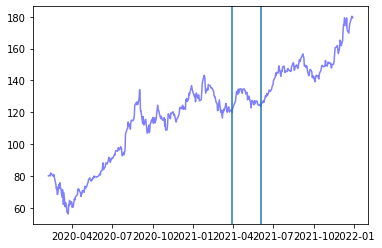

In [449]:
plt.plot(data["Close"], color = "blue", alpha = .5)
xcoords = [data.index[train_size], data.index[train_size+val_size]]
for xc in xcoords:
    plt.axvline(x=xc)

In [450]:
data.head()

,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,SPY_returns,Treasury_Yield_10_Years,Target
Date,,,,,,,,,,,,,,,,,,
2020-02-07,80.007500,117684000,79.195625,81.694409,76.696842,4.997567,79.195625,80.445017,77.946234,57.748864,79.436762,78.311923,79.502084,78.311923,1.124839,332.200012,1.578,80.387497
2020-02-10,80.387497,109348800,79.335875,81.770811,76.900939,4.869872,79.335875,80.553343,78.118407,58.818449,79.583029,78.465670,79.550417,78.515769,1.117359,334.679993,1.547,79.902496
2020-02-11,79.902496,94323200,79.369000,81.815814,76.922187,4.893627,79.369000,80.592407,78.145593,56.840648,79.632178,78.572101,79.577500,78.729039,1.060077,335.260010,1.590,81.800003
2020-02-12,81.800003,113730400,79.550500,82.148492,76.952509,5.195984,79.550500,80.849496,78.251505,62.196479,79.965689,78.811205,79.957708,78.992500,1.154484,337.420013,1.630,81.217499
2020-02-13,81.217499,94747600,79.719625,82.289127,77.150124,5.139002,79.719625,81.004376,78.434875,59.745402,80.158275,78.989449,80.107292,79.247116,1.168826,337.059998,1.617,81.237503


In [451]:
train_df = data[:train_size]
val_df = data[train_size: train_size+val_size]
test_df = data[train_size+val_size:]

In [452]:
train_df.head()

,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,SPY_returns,Treasury_Yield_10_Years,Target
Date,,,,,,,,,,,,,,,,,,
2020-02-07,80.007500,117684000,79.195625,81.694409,76.696842,4.997567,79.195625,80.445017,77.946234,57.748864,79.436762,78.311923,79.502084,78.311923,1.124839,332.200012,1.578,80.387497
2020-02-10,80.387497,109348800,79.335875,81.770811,76.900939,4.869872,79.335875,80.553343,78.118407,58.818449,79.583029,78.465670,79.550417,78.515769,1.117359,334.679993,1.547,79.902496
2020-02-11,79.902496,94323200,79.369000,81.815814,76.922187,4.893627,79.369000,80.592407,78.145593,56.840648,79.632178,78.572101,79.577500,78.729039,1.060077,335.260010,1.590,81.800003
2020-02-12,81.800003,113730400,79.550500,82.148492,76.952509,5.195984,79.550500,80.849496,78.251505,62.196479,79.965689,78.811205,79.957708,78.992500,1.154484,337.420013,1.630,81.217499
2020-02-13,81.217499,94747600,79.719625,82.289127,77.150124,5.139002,79.719625,81.004376,78.434875,59.745402,80.158275,78.989449,80.107292,79.247116,1.168826,337.059998,1.617,81.237503


# Normalization

In [453]:
# scaler = MinMaxScaler()
# #train_df[norm_cols] = scaler.fit_transform(train_df[norm_cols])

# train_df_norm = scaler.fit_transform(train_df)
# train_df = pd.DataFrame(train_df_norm, index=train_df.index, columns=train_df.columns)


In [454]:
# # scaler_val = MinMaxScaler()
# #val_df[norm_cols] = scaler.transform(val_df[norm_cols])

# # scaler_test = MinMaxScaler()
# #test_df[norm_cols] = scaler.transform(test_df[norm_cols])

# val_df_norm = scaler.transform(val_df)
# val_df = pd.DataFrame(val_df_norm, index=val_df.index, columns=val_df.columns)

# test_df_norm = scaler.transform(test_df)
# test_df = pd.DataFrame(test_df_norm, index=test_df.index, columns=test_df.columns)


In [455]:
train_df.head()

,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,SPY_returns,Treasury_Yield_10_Years,Target
Date,,,,,,,,,,,,,,,,,,
2020-02-07,80.007500,117684000,79.195625,81.694409,76.696842,4.997567,79.195625,80.445017,77.946234,57.748864,79.436762,78.311923,79.502084,78.311923,1.124839,332.200012,1.578,80.387497
2020-02-10,80.387497,109348800,79.335875,81.770811,76.900939,4.869872,79.335875,80.553343,78.118407,58.818449,79.583029,78.465670,79.550417,78.515769,1.117359,334.679993,1.547,79.902496
2020-02-11,79.902496,94323200,79.369000,81.815814,76.922187,4.893627,79.369000,80.592407,78.145593,56.840648,79.632178,78.572101,79.577500,78.729039,1.060077,335.260010,1.590,81.800003
2020-02-12,81.800003,113730400,79.550500,82.148492,76.952509,5.195984,79.550500,80.849496,78.251505,62.196479,79.965689,78.811205,79.957708,78.992500,1.154484,337.420013,1.630,81.217499
2020-02-13,81.217499,94747600,79.719625,82.289127,77.150124,5.139002,79.719625,81.004376,78.434875,59.745402,80.158275,78.989449,80.107292,79.247116,1.168826,337.059998,1.617,81.237503


In [456]:
#IS THIS OK???

scaler = MinMaxScaler()
scalerY = MinMaxScaler()

feature_cols = list(train_df.columns)[:-1]

train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

train_df[["Target"]] = scalerY.fit_transform(train_df[["Target"]])
val_df[["Target"]] = scalerY.transform(val_df[["Target"]])
test_df[["Target"]] = scalerY.transform(test_df[["Target"]])





In [457]:
train_df

,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,SPY_returns,Treasury_Yield_10_Years,Target
Date,,,,,,,,,,,,,,,,,,
2020-02-07,0.274672,0.186912,0.227757,0.176242,0.298799,0.004294,0.227757,0.202683,0.255099,0.549730,0.232862,0.191337,0.240655,0.203973,0.478082,0.626757,0.875101,0.279036
2020-02-10,0.279036,0.164967,0.229655,0.177246,0.301507,0.000000,0.229655,0.204136,0.257433,0.569682,0.234832,0.193557,0.241287,0.206856,0.477471,0.640984,0.849959,0.273466
2020-02-11,0.273466,0.125407,0.230103,0.177838,0.301789,0.000799,0.230103,0.204659,0.257801,0.532788,0.235495,0.195093,0.241642,0.209872,0.472790,0.644312,0.884834,0.295259
2020-02-12,0.295259,0.176503,0.232559,0.182212,0.302192,0.010965,0.232559,0.208106,0.259237,0.632696,0.239988,0.198545,0.246617,0.213598,0.480505,0.656704,0.917275,0.288569
2020-02-13,0.288569,0.126524,0.234848,0.184061,0.304814,0.009049,0.234848,0.210183,0.261722,0.586974,0.242582,0.201119,0.248574,0.217199,0.481677,0.654638,0.906732,0.288799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22,0.772935,0.171716,0.812851,0.781678,0.835196,0.193588,0.812851,0.801214,0.822096,0.364555,0.814221,0.858649,0.792467,0.855335,0.227111,0.973209,0.961071,0.763172
2021-03-23,0.763172,0.128419,0.810604,0.776384,0.836134,0.177675,0.810604,0.797402,0.821450,0.339299,0.814122,0.856517,0.793689,0.848356,0.238580,0.955482,0.923763,0.735033
2021-03-24,0.735033,0.110156,0.807045,0.771311,0.834274,0.169410,0.807045,0.793052,0.818718,0.269277,0.808960,0.851922,0.797756,0.841231,0.233276,0.944122,0.904298,0.740776


In [458]:
scaler.inverse_transform(train_df[feature_cols])

array([[ 8.00074997e+01,  1.17684000e+08,  7.91956253e+01, ...,
         1.12483862e+00,  3.32200012e+02,  1.57799995e+00],
       [ 8.03874969e+01,  1.09348800e+08,  7.93358753e+01, ...,
         1.11735934e+00,  3.34679993e+02,  1.54700005e+00],
       [ 7.99024963e+01,  9.43232000e+07,  7.93690002e+01, ...,
         1.06007656e+00,  3.35260010e+02,  1.59000003e+00],
       ...,
       [ 1.20089996e+02,  8.85305000e+07,  1.22002499e+02, ...,
        -1.87086327e+00,  3.87519989e+02,  1.61399996e+00],
       [ 1.20589996e+02,  9.88447000e+07,  1.21982499e+02, ...,
        -1.86050588e+00,  3.89700012e+02,  1.61399996e+00],
       [ 1.21209999e+02,  9.40712000e+07,  1.21979999e+02, ...,
        -1.78172986e+00,  3.95980011e+02,  1.65999997e+00]])

In [459]:
train_df

,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,SPY_returns,Treasury_Yield_10_Years,Target
Date,,,,,,,,,,,,,,,,,,
2020-02-07,0.274672,0.186912,0.227757,0.176242,0.298799,0.004294,0.227757,0.202683,0.255099,0.549730,0.232862,0.191337,0.240655,0.203973,0.478082,0.626757,0.875101,0.279036
2020-02-10,0.279036,0.164967,0.229655,0.177246,0.301507,0.000000,0.229655,0.204136,0.257433,0.569682,0.234832,0.193557,0.241287,0.206856,0.477471,0.640984,0.849959,0.273466
2020-02-11,0.273466,0.125407,0.230103,0.177838,0.301789,0.000799,0.230103,0.204659,0.257801,0.532788,0.235495,0.195093,0.241642,0.209872,0.472790,0.644312,0.884834,0.295259
2020-02-12,0.295259,0.176503,0.232559,0.182212,0.302192,0.010965,0.232559,0.208106,0.259237,0.632696,0.239988,0.198545,0.246617,0.213598,0.480505,0.656704,0.917275,0.288569
2020-02-13,0.288569,0.126524,0.234848,0.184061,0.304814,0.009049,0.234848,0.210183,0.261722,0.586974,0.242582,0.201119,0.248574,0.217199,0.481677,0.654638,0.906732,0.288799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22,0.772935,0.171716,0.812851,0.781678,0.835196,0.193588,0.812851,0.801214,0.822096,0.364555,0.814221,0.858649,0.792467,0.855335,0.227111,0.973209,0.961071,0.763172
2021-03-23,0.763172,0.128419,0.810604,0.776384,0.836134,0.177675,0.810604,0.797402,0.821450,0.339299,0.814122,0.856517,0.793689,0.848356,0.238580,0.955482,0.923763,0.735033
2021-03-24,0.735033,0.110156,0.807045,0.771311,0.834274,0.169410,0.807045,0.793052,0.818718,0.269277,0.808960,0.851922,0.797756,0.841231,0.233276,0.944122,0.904298,0.740776


## Data Preprocessing

In [460]:
train_x, train_y = train_df.iloc[:,:-1],train_df.iloc[:,-1]
train_x.head()


,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,ShortEMA,LongEMA,ShortMA,LongMA,MACD,SPY_returns,Treasury_Yield_10_Years
Date,,,,,,,,,,,,,,,,,
2020-02-07,0.274672,0.186912,0.227757,0.176242,0.298799,0.004294,0.227757,0.202683,0.255099,0.549730,0.232862,0.191337,0.240655,0.203973,0.478082,0.626757,0.875101
2020-02-10,0.279036,0.164967,0.229655,0.177246,0.301507,0.000000,0.229655,0.204136,0.257433,0.569682,0.234832,0.193557,0.241287,0.206856,0.477471,0.640984,0.849959
2020-02-11,0.273466,0.125407,0.230103,0.177838,0.301789,0.000799,0.230103,0.204659,0.257801,0.532788,0.235495,0.195093,0.241642,0.209872,0.472790,0.644312,0.884834
2020-02-12,0.295259,0.176503,0.232559,0.182212,0.302192,0.010965,0.232559,0.208106,0.259237,0.632696,0.239988,0.198545,0.246617,0.213598,0.480505,0.656704,0.917275
2020-02-13,0.288569,0.126524,0.234848,0.184061,0.304814,0.009049,0.234848,0.210183,0.261722,0.586974,0.242582,0.201119,0.248574,0.217199,0.481677,0.654638,0.906732


In [461]:
val_x, val_y = val_df.iloc[:,:-1],val_df.iloc[:,-1]
test_x, test_y = test_df.iloc[:,:-1],test_df.iloc[:,-1]


In [462]:
#was 7
WINDOW_SIZE = 30

In [463]:
def create_sequences(data, window = WINDOW_SIZE):
    seq = []
    for i in range(len(data)-window):
        record = []
        for j in range(window):
            
            record.append(data.iloc[i+j].values)
        seq.append(record)

    
    return seq 


train_seq = create_sequences(train_x)

In [464]:
def create_model_input(seq, y, window=WINDOW_SIZE):
    y = y[window:]
    assert len(seq) == len(y)
    seq_tensor = [torch.tensor(l) for l in seq]
    y_tensor = [torch.tensor(l).unsqueeze(0) for l in y]
    inout_seq = list(zip(seq_tensor, y_tensor))
    return inout_seq
    

In [465]:
train_y = train_y[WINDOW_SIZE:]

In [466]:
len(train_seq) == len(train_y)

True

In [467]:
train_x_seq, train_y_seq = np.array(train_seq), np.array(train_y)

In [468]:
train_x_seq.shape

(256, 30, 17)

In [469]:
#cover to tensors
train_seq_tensor = [torch.tensor(l) for l in train_seq]
train_y_tensor = [torch.tensor(l).unsqueeze(0) for l in train_y]

In [470]:
train_y_tensor[0].shape

torch.Size([1])

In [471]:
train_inout_seq = list(zip(train_seq_tensor, train_y_tensor))

In [472]:
train_inout_seq[0]

(tensor([[2.7467e-01, 1.8691e-01, 2.2776e-01, 1.7624e-01, 2.9880e-01, 4.2935e-03,
          2.2776e-01, 2.0268e-01, 2.5510e-01, 5.4973e-01, 2.3286e-01, 1.9134e-01,
          2.4065e-01, 2.0397e-01, 4.7808e-01, 6.2676e-01, 8.7510e-01],
         [2.7904e-01, 1.6497e-01, 2.2966e-01, 1.7725e-01, 3.0151e-01, 0.0000e+00,
          2.2966e-01, 2.0414e-01, 2.5743e-01, 5.6968e-01, 2.3483e-01, 1.9356e-01,
          2.4129e-01, 2.0686e-01, 4.7747e-01, 6.4098e-01, 8.4996e-01],
         [2.7347e-01, 1.2541e-01, 2.3010e-01, 1.7784e-01, 3.0179e-01, 7.9874e-04,
          2.3010e-01, 2.0466e-01, 2.5780e-01, 5.3279e-01, 2.3549e-01, 1.9509e-01,
          2.4164e-01, 2.0987e-01, 4.7279e-01, 6.4431e-01, 8.8483e-01],
         [2.9526e-01, 1.7650e-01, 2.3256e-01, 1.8221e-01, 3.0219e-01, 1.0965e-02,
          2.3256e-01, 2.0811e-01, 2.5924e-01, 6.3270e-01, 2.3999e-01, 1.9855e-01,
          2.4662e-01, 2.1360e-01, 4.8050e-01, 6.5670e-01, 9.1727e-01],
         [2.8857e-01, 1.2652e-01, 2.3485e-01, 1.8406e-01, 3.

## LSTM

In [473]:
NUM_FEATURES = 17
BATCH_SIZE = 1
class NetworkReg(torch.nn.Module):
    def __init__(self, input_size = NUM_FEATURES, hidden_size = 128, output_size = 1, batch_size = BATCH_SIZE, dropout = 0.2, num_layers=2):
        super().__init__()
        self.input_size = input_size #num of features
        self.hidden_size = hidden_size
        self.output_size = output_size    
        self.batch_size = batch_size
        self.num_layers = num_layers  

        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.lstm = torch.nn.LSTM(self.hidden_size,  hidden_size=self.hidden_size, num_layers = self.num_layers, dropout=dropout)
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        

    def forward(self, input_seq):
        x = self.linear_1(input_seq)
        x = self.relu(x)
        hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_size), torch.zeros(self.num_layers, self.batch_size, self.hidden_size))


        #print(self.hidden_cell[0].shape)
        #print(input_seq.shape)
        lstm_out, hidden = self.lstm(x, hidden)
        
        out = self.linear(hidden[0])
        # print(out)
        return out[-1]

In [474]:
val_seq = create_sequences(val_x)
val_inout_seq = create_model_input(val_seq, val_y)

In [475]:
test_seq = create_sequences(test_x)
test_inout_seq = create_model_input(test_seq, test_y)

In [476]:
# epochs = 40

# #before stopped: hidden_sizes = [32, 64, 128, 256]
# #second stop: hidden_sizes = [128, 256]
# #hidden_sizes = [256]

# #hidden_sizes = [32, 64, 128, 256]
# hidden_sizes = [128, 256]
# n_dropouts = [0, .2, .4, .6]
# num_layers = [1,2,3,4]

# lrs = [.01,.001,.0001]
# opt_texts = ["adam", "sgd"]

# #stopped at: hs_128_do_0.2_nl_2_lr_0.0001_opt_adam_03-04-1053

# for hidden_size in hidden_sizes:
#     for dropout in n_dropouts:
        
#         for num_layer in num_layers:
#             print(hidden_size)
#             print(dropout)
#             print(num_layer)
#             model = NetworkReg(hidden_size=hidden_size, dropout=dropout, num_layers=num_layer)
            
#             for lr in lrs:
#                 for opt_text in opt_texts:
#                     if opt_text == "adam":
#                         opt = torch.optim.Adam(model.parameters(),lr=lr)
#                     else:
#                         opt = torch.optim.SGD(model.parameters(),lr=lr)

#                     if (hidden_size == 128 and dropout != 0 and num_layer != 1) or (hidden_size != 128):
#                         # UGHHHHHHHH WHYYYYYY WERE THESE LINES HEREEEEEEEE ?!??!?!?!?!?
                        
#                         #model = NetworkClassifier()
#                         loss_func = torch.nn.CrossEntropyLoss()
#                         # opt = torch.optim.Adam(model.parameters(),lr=lr)


#                         log_name = 'hs_' + str(hidden_size) + "_do_" + str(dropout) + "_nl_"+ str(num_layer) + "_lr_" + str(lr) + "_opt_" + opt_text + "_" + datetime.now().strftime("%m-%d-%H%M")
#                         print(log_name)
#                         for epoch in range(epochs):
#                             print("epoch", epoch)
#                             train_loss_total = 0

#                             train_logger = tb.SummaryWriter('./writer/' + log_name + '/train', flush_secs = 1)
#                             for i, (x, y) in enumerate(train_inout_seq):
#                                 model.train()
                            
#                                 opt.zero_grad()
                                
#                                 x = x.view(len(x), 1, -1)
#                                 #print(x.shape)

#                                 #print("running")
#                                 out = model(x.float())
#                                 # print(out.shape)
#                                 # print(y.shape)

#                                 # print(out)
#                                 y_pred = torch.argmax(out, dim=1)
#                                 # print(torch.argmax(out, dim=1))

#                                 loss = loss_func(out,y.type(torch.LongTensor))
#                                 loss.backward()
#                                 opt.step()

#                                 train_loss_total += loss.item()
                            

#                             model.eval()
#                             #val_conf = ConfusionMatrix()
#                             val_logger = tb.SummaryWriter('./writer/' + log_name + '/val', flush_secs = 1)
#                             val_loss_total = 0
#                             for i, (x, y) in enumerate(test_inout_seq):
#                                 #print(x)
#                                 #print(model(x.view(len(x), 1, -1).float()))
#                                 out = model(x.view(len(x), 1, -1).float())
#                                 loss = loss_func(out,y.type(torch.LongTensor))

#                                 val_loss_total += loss.item()

#                             avg_train_loss = train_loss_total/len(train_inout_seq)
#                             avg_val_loss = val_loss_total/len(val_inout_seq)
                            
#                             train_logger.add_scalar("Loss_train", avg_train_loss, epoch)
#                             val_logger.add_scalar("Loss_val", avg_val_loss, epoch)
                        
#                         torch.save(model, "models/%s.pt" % log_name)  


In [477]:
epochs = 35
lr = .0001
hidden_size = 64
dropout = .2
num_layer = 2
opt_text = 'adam'

#model = NetworkClassifier(hidden_size = 64, dropout=.2, num_layers=2)
#model = NetworkClassifier(hidden_size = 256, num_layers = 2, dropout=.4)
model = NetworkReg(hidden_size = hidden_size, num_layers = num_layer, dropout=dropout)

#adam .001, 100


#opt = torch.optim.SGD(model.parameters(),lr=lr)
opt = torch.optim.Adam(model.parameters(),lr=lr)

#trying decay
#decayRate = 0.96
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=decayRate)

loss_func = torch.nn.MSELoss()


log_name = 'works____epochs_' + str(epochs)+ '_hs_' + str(hidden_size) + "_do_" + str(dropout) + "_nl_"+ str(num_layer) + "_lr_" + str(lr) + "_opt_" + opt_text + "_" + datetime.now().strftime("%m-%d-%H%M")

for epoch in range(epochs):
    print("epoch", epoch)
    train_loss_total = 0
    model.train()
    train_logger = tb.SummaryWriter('./writer/' + log_name + '/train', flush_secs = 1)
    for i, (x, y) in enumerate(train_inout_seq):
        
    
        opt.zero_grad()
        x = x.view(len(x), 1, -1)

        out = model(x.float())
        loss = loss_func(out,y.view(-1,1))

        loss.backward()
        opt.step()

        train_loss_total += loss.item()
    

    model.eval()
    #val_conf = ConfusionMatrix()
    val_logger = tb.SummaryWriter('./writer/' + log_name + '/val', flush_secs = 1)
    val_loss_total = 0
    for i, (x, y) in enumerate(val_inout_seq):
        #print(x)
        #print(model(x.view(len(x), 1, -1).float()))
        out = model(x.view(len(x), 1, -1).float())
        loss = loss_func(out,y.view(-1,1))

        val_loss_total += loss.item()

    avg_train_loss = train_loss_total/len(train_inout_seq)
    avg_val_loss = val_loss_total/len(val_inout_seq)
    
    train_logger.add_scalar("Loss_train", avg_train_loss, epoch)
    val_logger.add_scalar("Loss_val", avg_val_loss, epoch)

    print(avg_train_loss, avg_val_loss)

torch.save(model, "models_reg/%s.pt" % log_name)  


epoch 0
0.00845309149274144 0.0013197739165608415
epoch 1


KeyboardInterrupt: 

In [489]:
#model = torch.load("models_reg\works____epochs_35_hs_64_do_0.2_nl_2_lr_0.0001_opt_adam_04-19-2200.pt")

In [ ]:
# train_df[norm_cols] = scaler.inverse_transform(train_df[norm_cols])
# val_df[norm_cols] = scaler_val.inverse_transform(val_df[norm_cols])
# test_df[norm_cols] = scaler_test.inverse_transform(test_df[norm_cols])




In [ ]:
# val_df_inv = scaler.inverse_transform(val_df)
# test_df_inv = scaler.inverse_transform(test_df)

# train_df_inv = scaler.inverse_transform(train_df)
# train_df = pd.DataFrame(train_df_inv, index=train_df.index, columns=train_df.columns)

# val_df = pd.DataFrame(val_df_inv, index=val_df.index, columns=val_df.columns)
# test_df = pd.DataFrame(test_df_inv, index=test_df.index, columns=test_df.columns)


In [528]:

def get_trading_signals(df, window_size=WINDOW_SIZE, buy_threshold=.0015, sell_threshold=.0015, lag=0, stop_loss_percent = .015):
    # df["Pred Buy Actual"] = [df.iloc[i]["Close"] if df.iloc[i+lag]["percentDiff"] >= threshold else np.nan for i in range(len(df)-lag)] + [np.nan] * lag
    # df["Pred Sell Actual"] = [df.iloc[i]["Close"] if df.iloc[i+lag]["percentDiff"] <= -threshold else np.nan for i in range(len(df)-lag)] + [np.nan] * lag

    df["Pred Buy Pred"] = [df.iloc[i]["Preds"] if df.iloc[i+lag]["percentDiff"] >= buy_threshold else np.nan for i in range(len(df)-lag)] + [np.nan] * lag
    df["Pred Sell Pred"] = [df.iloc[i]["Preds"] if df.iloc[i+lag]["percentDiff"] <= -sell_threshold else np.nan for i in range(len(df)-lag)]+ [np.nan] * lag
    

    buys = [df.iloc[i]["Close"] if df.iloc[i+lag]["percentDiff"] >= buy_threshold else np.nan for i in range(len(df)-lag)] + [np.nan] * lag
    sells = [df.iloc[i]["Close"] if df.iloc[i+lag]["percentDiff"] <= -sell_threshold else np.nan for i in range(len(df)-lag)] + [np.nan] * lag

    pred_buy_actual = []
    pred_sell_actual = []
    stop_loss = []
    
    bought = False
    last_buy_price = np.nan
    #na = float('nan')

    for i in range(len(buys)):
        if (not math.isnan(buys[i])) and (not bought):
            pred_buy_actual.append(buys[i])
            pred_sell_actual.append(np.nan)
            stop_loss.append(np.nan)
            bought = True
            last_buy_price = buys[i]
        elif (not math.isnan(sells[i])) and (bought):
            pred_buy_actual.append(np.nan)
            pred_sell_actual.append(sells[i])
            stop_loss.append(np.nan)
            bought = False
        
        elif(last_buy_price * (1-stop_loss_percent) > df.iloc[i]["Close"]) and (bought):
            pred_buy_actual.append(np.nan)
            pred_sell_actual.append(df.iloc[i]["Close"])
            stop_loss.append(df.iloc[i]["Close"])
            bought = False
        else:
            pred_buy_actual.append(np.nan)
            pred_sell_actual.append(np.nan)
            stop_loss.append(np.nan)
    
    df["Pred Buy Actual"] = pred_buy_actual
    df["Pred Sell Actual"] = pred_sell_actual
    df["Stop Loss"] = stop_loss

        
    return df


def plot_preds(df_set, show_signals = False, buy_threshold=.0015, sell_threshold=.0015, window_size=WINDOW_SIZE, lag=0, show_pred = True):
    df = df_set.copy()
    #display(df)
    df[feature_cols] = scaler.inverse_transform(df[feature_cols])
   

    
    fig = plt.figure(figsize=(8, 6))
    plt.plot(df["Close"], color = "blue", alpha = .5)

    if show_pred:
        df[["Preds"]] = scalerY.inverse_transform(df[["Preds"]])
        plt.plot(df["Preds"], color = "red", alpha = .5)
        #plt.plot(df["Target"], color= "green")
    #display(df)

    if show_signals:
        df = get_trading_signals(df, buy_threshold=buy_threshold, sell_threshold=sell_threshold, lag=lag)
        if(not df["Pred Buy Actual"].isnull().all()):
            plt.scatter(df.index, df["Pred Buy Actual"], color = 'green', marker="^", alpha=1)
        if(not df["Pred Sell Actual"].isnull().all()):
            plt.scatter(df.index, df["Pred Sell Actual"], color = 'red', marker="v", alpha=1)
        
        if(not df["Stop Loss"].isnull().all()):
            plt.scatter(df.index, df["Stop Loss"], color = 'purple', marker="v", alpha=1)
        
        if show_pred:
            if(not df["Pred Buy Pred"].isnull().all()):
                plt.scatter(df.index, df["Pred Buy Pred"], color = 'green', marker="^", alpha=1)
            if(not df["Pred Sell Pred"].isnull().all()):
                plt.scatter(df.index, df["Pred Sell Pred"], color = 'red', marker="v", alpha=1)

    plt.show() 
    # fig.savefig('ML_charts/{}_target_chart.png'.format(symbol))
    plt.close(fig)

    


    plt.show() 
    # fig.savefig('ML_charts/{}_target_chart.png'.format(symbol))
   
    plt.close(fig)


In [529]:
#overfits at 100 epochs
print(feature_cols)

['Close', 'Volume', 'Mid BBand', 'Top BBand', 'Bot BBand', 'Volatility', 'Mid BBand Narrow', 'Top BBand Narrow', 'Bot BBand Narrow', 'RSI', 'ShortEMA', 'LongEMA', 'ShortMA', 'LongMA', 'MACD', 'SPY_returns', 'Treasury_Yield_10_Years']


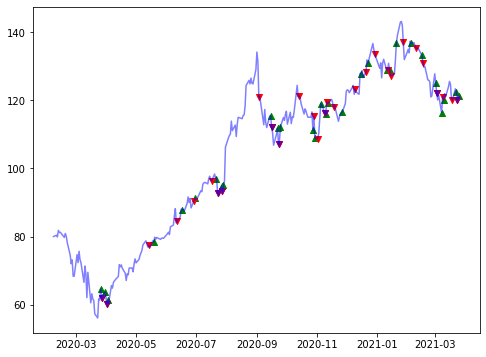

In [530]:
model.eval()
window = WINDOW_SIZE
preds = []



for i, (x, y) in enumerate(train_inout_seq):
    #print(x)
    #print(model(x.view(len(x), 1, -1).float()))
    preds.append(model(x.view(len(x), 1, -1).float()).item())


train_df["Preds"] = [np.nan]*window + preds

train_df["percentDiff"] = train_df["Preds"].pct_change()

# train_df_inv = scaler.inverse_transform(train_df)
# train_df = pd.DataFrame(train_df_inv, index=train_df.index, columns=train_df.columns)

plot_preds(train_df, show_signals=True, buy_threshold=.0001, sell_threshold=.0002, show_pred=False)

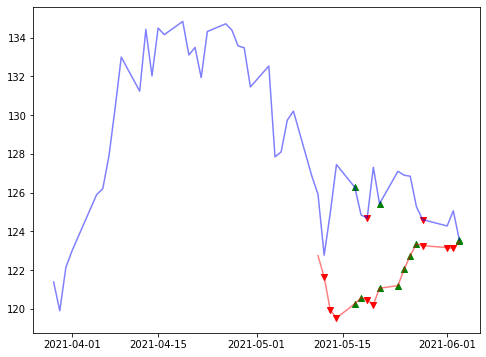

In [531]:
model.eval()

preds = []

for i, (x, y) in enumerate(val_inout_seq):
    #print(x)
    #print(model(x.view(len(x), 1, -1).float()))
    preds.append(model(x.view(len(x), 1, -1).float()).item())

val_df["Preds"] = [np.nan]*window + preds

val_df["percentDiff"] = val_df["Preds"].pct_change()

plot_preds(val_df, show_signals=True,  buy_threshold=.0001, sell_threshold=.0002, show_pred = True)
    

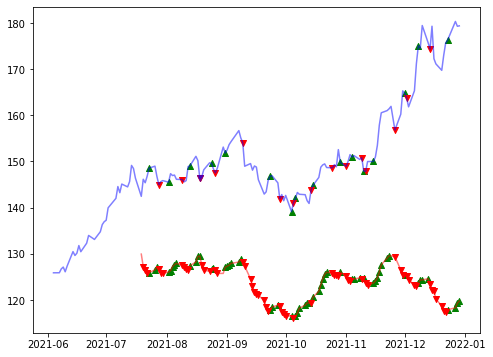

In [532]:
model.eval()

preds = []

for i, (x, y) in enumerate(test_inout_seq):
    #print(x)
    #print(model(x.view(len(x), 1, -1).float()))
    preds.append(model(x.view(len(x), 1, -1).float()).item())

test_df["Preds"] = [np.nan]*window + preds

test_df["percentDiff"] = test_df["Preds"].pct_change()

plot_preds(test_df, show_signals=True,  buy_threshold=.0001, sell_threshold=.0002, show_pred = True)

In [533]:
result_train = get_trading_signals(train_df,  buy_threshold=.0001, sell_threshold=.0002)
result_train.head()

,Close,Volume,Mid BBand,Top BBand,Bot BBand,Volatility,Mid BBand Narrow,Top BBand Narrow,Bot BBand Narrow,RSI,...,SPY_returns,Treasury_Yield_10_Years,Target,Preds,percentDiff,Pred Buy Pred,Pred Sell Pred,Pred Buy Actual,Pred Sell Actual,Stop Loss
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-07,0.274672,0.186912,0.227757,0.176242,0.298799,0.004294,0.227757,0.202683,0.255099,0.549730,...,0.626757,0.875101,0.279036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-10,0.279036,0.164967,0.229655,0.177246,0.301507,0.000000,0.229655,0.204136,0.257433,0.569682,...,0.640984,0.849959,0.273466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-11,0.273466,0.125407,0.230103,0.177838,0.301789,0.000799,0.230103,0.204659,0.257801,0.532788,...,0.644312,0.884834,0.295259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-12,0.295259,0.176503,0.232559,0.182212,0.302192,0.010965,0.232559,0.208106,0.259237,0.632696,...,0.656704,0.917275,0.288569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-13,0.288569,0.126524,0.234848,0.184061,0.304814,0.009049,0.234848,0.210183,0.261722,0.586974,...,0.654638,0.906732,0.288799,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [534]:
import math

In [535]:
def buy_hold_profit(df, window_size=WINDOW_SIZE):

    buy_hold_profit = df["Close"][-1] - df["Close"][window_size]
    return buy_hold_profit

In [536]:
def get_total_profit(data):
   # display(data)
    profit = 0
    i = 0 
    buyIndex = -1
    sellIndex = -1

    buyCol = data.columns.get_loc("Pred Buy Actual")
    sellCol = data.columns.get_loc("Pred Sell Actual")
    closeCol = data.columns.get_loc("Close")

    while i < len(data):
        if(not pd.isnull(data.iloc[i,buyCol]) and buyIndex == -1): 
            buyIndex = i
        
        if(not pd.isnull(data.iloc[i,sellCol]) and buyIndex != -1):
            sellIndex = i

            profit += (data.iloc[sellIndex,sellCol] - data.iloc[buyIndex,buyCol])
            
            buyIndex = -1
            sellIndex = -1
        if((i+1) == len(data) and buyIndex != -1):
            lastRow = -1
            while (pd.isnull(data.iloc[lastRow, closeCol])):
                lastRow -= 1


            profit += data.iloc[lastRow, closeCol] - data.iloc[buyIndex, buyCol]
        i+=1
    return profit

In [537]:
def unnormalize(df):
    df_un_norm = df.copy()
    df_un_norm[feature_cols] = scaler.inverse_transform(df_un_norm[feature_cols])
    df_un_norm[["Preds"]] = scalerY.inverse_transform(df_un_norm[["Preds"]])
    return df_un_norm

In [538]:
pd.options.mode.chained_assignment = None  # default='warn'
#get rid of settingwithcopywarning message

In [540]:
best_profit = float('-inf')
best_thresh = 0

for i in [x / 10000.0 for x in range(0, 200, 1)]:
    trade = get_total_profit(get_trading_signals(unnormalize(train_df),  buy_threshold=.0001, sell_threshold=.0002))
    #null = buy_hold_profit(get_trading_signals(unnormalize(train_df), threshold=i))
    if trade > best_profit:
        best_profit = trade
        best_thresh = i




KeyboardInterrupt: 

In [504]:
(best_thresh, best_profit)

(0.0003, 59.95998001098634)

In [551]:
print("trading: $", get_total_profit(get_trading_signals(unnormalize(train_df), buy_threshold=.0001, sell_threshold=.0001)))
print("buy & hold $", buy_hold_profit(get_trading_signals(unnormalize(train_df), buy_threshold=.0001, sell_threshold=.0001)))

trading: $ 52.299983978271484
buy & hold $ 65.11750030517578


In [546]:
print("trading: $",get_total_profit(get_trading_signals(unnormalize(val_df),  buy_threshold=.0001, sell_threshold=.0001)))
print("buy & hold $",buy_hold_profit(get_trading_signals(unnormalize(val_df),  buy_threshold=.0001, sell_threshold=.0001)))

trading: $ -2.399993896484361
buy & hold $ -2.3700027465820312


In [544]:
print("trading: $",get_total_profit(get_trading_signals(unnormalize(test_df),  buy_threshold=.0001, sell_threshold=.0001)))
print("buy & hold $",buy_hold_profit(get_trading_signals(unnormalize(test_df),  buy_threshold=.0001, sell_threshold=.0001)))

trading: $ 9.259979248046903
buy & hold $ 36.93000793457031
